In [ ]:
import sys

sys.path.append("../")

import pandas as pd
from dotenv import load_dotenv

load_dotenv()
import os
import sqlite3

DB_PATH = os.getenv("DB_PATH")

conn = sqlite3.connect(DB_PATH)
pd.options.mode.chained_assignment = None

only_country = False

# Individuals Regions
df_ind_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_ind_regions = df_ind_regions.drop('region_code', axis=1)


## CLEAN WITH MANUAL REGIONS

# form this document: https://docs.google.com/spreadsheets/d/1xfYOFveqGTxeHbmVoq6svZ4c8AczhyKriUHLfEV8AjA/edit#gid=848448289

df_manual_regions = pd.read_csv('manual_data/Cultural Index cleaning 05_02_2024 - Sheet1.csv')
df_manual_regions_1 = df_manual_regions[['individual_wikidata_id', 'manual_region_name']]
df_manual_regions_1 = df_manual_regions_1.dropna()

df_manual_regions_2 = df_manual_regions[['individual_wikidata_id', 'manual_region_name_2']]
df_manual_regions_2 = df_manual_regions_2.dropna()

df_manual_regions_2 = df_manual_regions_2.rename(columns={'manual_region_name_2':'manual_region_name'})
df_manual_regions_3 = df_manual_regions[['individual_wikidata_id', 'manual_region_name_3']]
df_manual_regions_3 = df_manual_regions_3.rename(columns={'manual_region_name_3':'manual_region_name'})
df_manual_regions_3 = df_manual_regions_3.dropna()

df_concat = pd.concat([df_manual_regions_1, df_manual_regions_2, df_manual_regions_3])
df_concat = df_concat.reset_index(drop=True)

merged_df = pd.merge(df_concat, df_ind_regions,on = 'individual_wikidata_id', how='outer')

merged_df['manual_region_name'] = merged_df['manual_region_name'].fillna(merged_df['region_name'])
merged_df = merged_df.drop(columns=['region_name'])
merged_df = merged_df.rename(columns={'manual_region_name':'region_name'})
merged_df = merged_df.drop_duplicates()

df_ind_regions = merged_df.copy()


In [ ]:
# Years
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)

df_ind_birthyear = df_ind[["individual_wikidata_id", "birthyear"]].drop_duplicates()
df_ind_deathyear = pd.read_sql_query("SELECT * FROM deathyear", conn)
df_ind_year = pd.merge(df_ind_birthyear, df_ind_deathyear, on = 'individual_wikidata_id', how = 'outer')


df_ind_year['birthyear'][(df_ind_year['birthyear'] < 0) & 
            (df_ind_year['birthyear'] % 100 == 0) & 
            (df_ind_year['deathyear'].isna())] = df_ind_year['birthyear'] + 50


In [ ]:
df_ind_year[df_ind_year['individual_wikidata_id']=='Q44233']

,individual_wikidata_id,birthyear,deathyear
127490,Q44233,-750.0,NaN


In [ ]:
# Function to calculate productive_year
def calculate_productive_year(row):
    if pd.isna(row['birthyear']):
        return row['deathyear']
    productive_year = row['birthyear'] + 35
    if pd.notna(row['deathyear']) and productive_year > row['deathyear']:
        return row['deathyear']
    return productive_year


# Apply the function to the DataFrame
df_ind_year['productive_year'] = df_ind_year.apply(calculate_productive_year, axis=1)
#df_ind_year = df_ind_year[df_ind_year['productive_year']<=1880]

In [ ]:
df_ind_year[df_ind_year['individual_wikidata_id']=='Q6691']

,individual_wikidata_id,birthyear,deathyear,productive_year
95337,Q6691,-900.0,-800.0,-865.0


In [ ]:

df_ind_year = df_ind_year[~df_ind_year['productive_year'].isna()]

temporal_resolution = 10
df_ind_year["decade"] = df_ind_year["productive_year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)

#df_ind_year = df_ind_year[df_ind_year['productive_year']<=1880]

df_ind_year[df_ind_year['individual_wikidata_id']=='Q6691']

,individual_wikidata_id,birthyear,deathyear,productive_year,decade
95337,Q6691,-900.0,-800.0,-865.0,-860


In [ ]:
df_catalogs_id = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_catalogs = pd.read_sql_query("SELECT * FROM identifiers", conn)


if only_country:
    df_catalogs = df_catalogs[['identifiers_wikidata_id', 'country_name']].dropna()
    df_cat = pd.merge(df_catalogs_id, df_catalogs, on = 'identifiers_wikidata_id')
    df_cat = df_cat[['individual_wikidata_id','individual_name', 'country_name']].drop_duplicates()
    df_cat = df_cat.groupby(['individual_name', 'individual_wikidata_id'])['country_name'].count().rename('score').reset_index()
    df_cat = df_cat.sort_values('score', ascending=False).reset_index(drop=True)
else:
    df_cat = df_catalogs_id.groupby(['individual_name', 'individual_wikidata_id'])['identifiers_wikidata_id'].count().rename('score').reset_index()
    df_cat = df_cat.sort_values('score', ascending=False).reset_index(drop=True)
    
df_final = pd.merge(df_ind_year, df_cat, on = 'individual_wikidata_id')
df_final = pd.merge(df_final, df_ind_regions, on = ['individual_wikidata_id', 'individual_name'])
df_final = df_final.drop(['birthyear', 'deathyear'], axis=1)

df_final = df_final.drop_duplicates()

df_final.to_csv('results/df_individuals_score.csv')

,individual_wikidata_id,productive_year,decade,individual_name,score,region_name
435843,Q243201,1774.0,1770,Grigory Potemkin,64,Slav world


In [8]:
test = df_final[df_final['region_name']=='Arabian peninsula']
test = test[test['decade']<=800]
test = test.sort_values('decade', ascending=True)


In [ ]:
df_final.sort_values('score', ascending=False).sample(3)

,individual_wikidata_id,productive_year,decade,individual_name,score,region_name
210801,Q1581143,1524.0,1520,Hans Luterer,7,Germany
156313,Q106066464,1873.0,1870,Louise Nyström-Hamilton,13,Northwestern Europe
96061,Q18576901,1795.0,1800,Robert Deverell,10,British Islands


### Make scores for regions

In [10]:
import math

def get_century(decade):
    return math.ceil(decade / 100)

In [11]:
# Make groups
df_group = df_final[['individual_wikidata_id', 'region_name', 'decade', 'score']].drop_duplicates()
df_group = df_group.reset_index(drop=True)
df_group['score'] = 1

df_group = df_group.groupby(['region_name', 'decade'])['score'].sum().reset_index()

In [12]:
min_individuals = 8

def filter_by_number_of_individuals(df_group, min_individuals = 8):


    df_group['century'] = df_group['decade'].apply(get_century)


    df_start = df_group.copy()

    # Applying the function to the 'decade' column
    df_start['century'] = df_start['decade'].apply(get_century)
    df_start = df_start.groupby(['region_name', 'century'])['score'].sum().reset_index()
    df_start= df_start.reset_index()

    # Filter rows with score >= 10
    filtered_df = df_start[df_start['score'] >= min_individuals]

    # Get index of the first occurrence of each region
    indices = filtered_df.groupby('region_name').apply(lambda x: x.index[0])

    df_index = indices.reset_index()
    df_index.columns = ['region_name', 'min_index']


    # For every region filter by the min century
    final_new_region = []
    for region in df_index['region_name'].unique():
        region_min_index = df_index[df_index['region_name']==region]['min_index'].iloc[0]
        df_filtered_region = df_start[(df_start['region_name']==region)&(df_start['index']>=region_min_index)]
        final_new_region.append(df_filtered_region)
    df_final_new_region = pd.concat([x for x in final_new_region])
    df_final_new_region = df_final_new_region[['region_name', 'century']].copy()


    df_final_group = pd.merge(df_group, df_final_new_region, on = ['region_name', 'century'])
    df_final_group = df_final_group.reset_index(drop=True)

    return df_final_group

df_final_group = filter_by_number_of_individuals(df_group, min_individuals = 8)
df_final_group[df_final_group['region_name']=='Chinese world']

,region_name,decade,score,century
751,Chinese world,-280,1,-2
752,Chinese world,-270,1,-2
753,Chinese world,-260,2,-2
754,Chinese world,-240,2,-2
755,Chinese world,-230,2,-2
...,...,...,...,...
943,Chinese world,1840,50,19
944,Chinese world,1850,43,19
945,Chinese world,1860,66,19
946,Chinese world,1870,58,19


### this is a function to find the earlier date for every region with at least n indiviudla in a century


In [13]:
df_group = df_final_group.copy()
df_group.to_sql('region_score',conn, if_exists = 'replace', index=False)
df_group.to_csv('results/df_region_score.csv')

In [14]:
# Individuals that are only scientists
df_scientists = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
df_scientists = df_scientists[df_scientists['occupations_category'].str.contains('science')]

top_scientific_occupations = df_scientists.occupations_name.value_counts()
top_scientific_occupations = top_scientific_occupations.head(50).index
occupations_to_remove = ['pedagogue','explorer','music pedagogue', 'land surveyor', 'music theorist', 'folklorist', 'conquistador', 'urban planner', 'settler']
filtered_occupation_list = [occupation for occupation in top_scientific_occupations if occupation not in occupations_to_remove]
df_scientists = df_scientists[df_scientists['occupations_name'].isin(filtered_occupation_list)]

list_scientists = list(set(df_scientists['individual_wikidata_id']))
df_final_scientists = df_final[df_final['individual_wikidata_id'].isin(list_scientists)]
len(df_final_scientists)

df_final_scientists = df_final_scientists.drop_duplicates()
df_final_scientists.to_csv('results/df_individuals_score_science.csv')

### Make groups for scientists in regions

In [15]:
# Make groups
df_group = df_final_scientists[['individual_wikidata_id', 'region_name', 'decade', 'score']].drop_duplicates()
df_group = df_group.reset_index(drop=True)
df_group['score'] = 1

In [16]:


df_group = df_group.groupby(['region_name', 'decade'])['score'].sum().reset_index()
df_group.to_sql('region_score_science',conn, if_exists = 'replace', index=False)
df_group.to_csv('results/df_region_score_science.csv')

## Make complexity score for regions

In [17]:
df_occupations = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
df_occupations = df_occupations[df_occupations['occupations_category'].str.contains('science')]

In [18]:

df_complexity = pd.merge(df_final,df_occupations, on = 'individual_wikidata_id')
df_complexity_group = df_complexity[['occupations_wikidata_id', 'region_name', 'decade']].copy()
df_complexity_group = df_complexity_group.groupby(['region_name', 'decade'])['occupations_wikidata_id'].apply(lambda x : len(set(x))).reset_index()
df_complexity_group = df_complexity_group.rename(columns={'occupations_wikidata_id':'score'})
df_test = df_complexity[['individual_wikidata_id', 'occupations_wikidata_id', 'decade', 'region_name']]
df_test['decade'] = df_test['decade'].apply(lambda x: round(x / 100) * 100)

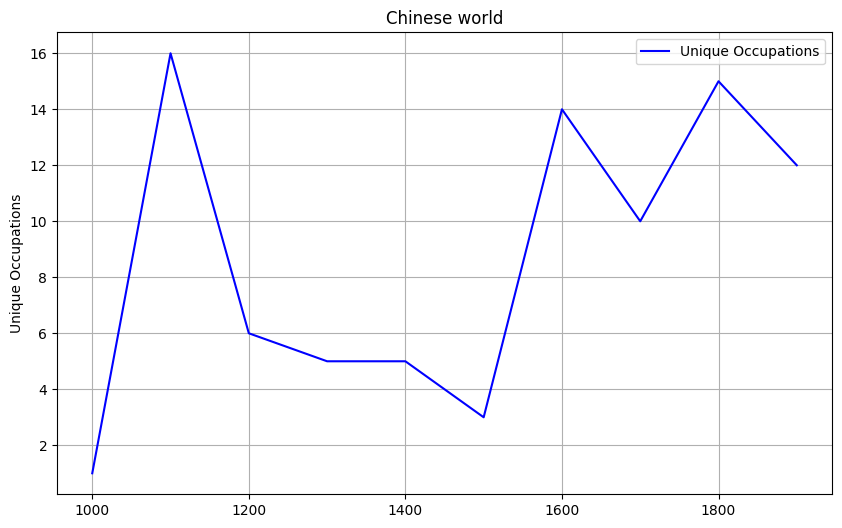

In [19]:


df_complexity_total = df_test.groupby(['decade', 'region_name'])['occupations_wikidata_id'].apply(lambda x: len(set(x))).reset_index()
test = df_complexity_total[df_complexity_total['region_name']=='Chinese world']
test = test[test['decade']>=900]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test['decade'], test['occupations_wikidata_id'], label='Unique Occupations', color='blue')
plt.xlabel('')
plt.ylabel('Unique Occupations')
plt.title('Chinese world')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from scipy.stats import sem, t
import random


# Define a function to calculate unique occupations in a sample
def calculate_unique_occupations(sample_data):
    return len(sample_data['occupations_wikidata_id'].unique())

# Number of samples
num_samples = 50
n_ind = 5

grouped = df_test.groupby(['region_name', 'decade'])
results = []
for (region, decade), group in grouped:
    sample_results = []
    for _ in range(num_samples):
        if len(group)<n_ind:
              sample = group
        else:
            sample = group.sample(n_ind)
        # n_unique_ind = list(set(group.individual_wikidata_id))
        # if len(n_unique_ind)<n_ind:
        #     sample = group
        # else:
        #     sample_individuals = random.sample(n_unique_ind, n_ind)
        #     sample = group[group['individual_wikidata_id'].isin(sample_individuals)]
        unique_occupations = calculate_unique_occupations(sample)
        sample_results.append(unique_occupations)
    median_unique_occupations = np.median(sample_results)
    ci = t.interval(0.95, len(sample_results) - 1, loc=np.median(sample_results), scale=sem(sample_results))
    results.append({'region_name': region, 'decade': decade, 'median_unique_occupations': median_unique_occupations,
                    'lower_bound': ci[0], 'upper_bound': ci[1]})


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [21]:

# Create a DataFrame for the results
result_df = pd.DataFrame(results)
result_df['lower_bound'].fillna(result_df['median_unique_occupations'], inplace=True)
result_df['upper_bound'].fillna(result_df['median_unique_occupations'], inplace=True)
result_df['median_unique_occupations'] = result_df['median_unique_occupations'].astype(float)
result_df['lower_bound'] = result_df['lower_bound'].astype(float)
result_df['upper_bound'] = result_df['upper_bound'].astype(float)

result_df['decade'] = result_df['decade'].astype(int)
result_df.to_csv('results/df_region_score_complexity.csv')

test = result_df[result_df['region_name']=='Chinese world']
test = test[test['decade']>=900]



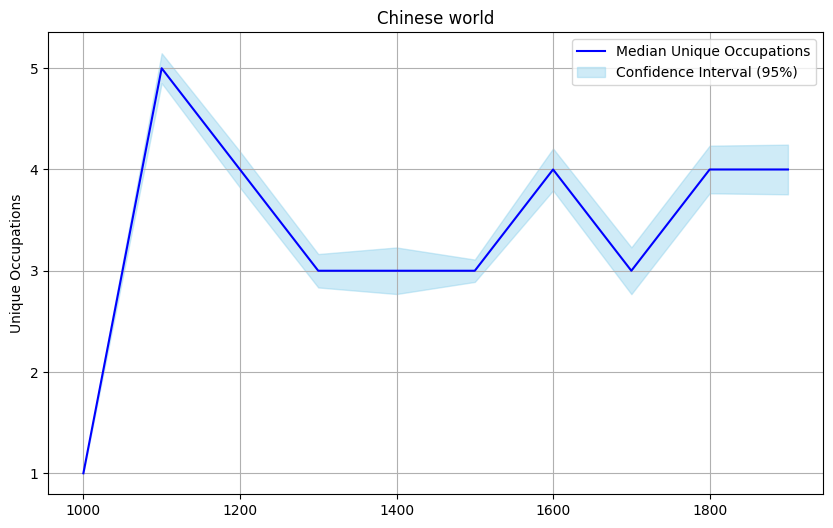

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test['decade'], test['median_unique_occupations'], label='Median Unique Occupations', color='blue')
plt.fill_between(test['decade'], test['lower_bound'], test['upper_bound'], color='skyblue', alpha=0.4, label='Confidence Interval (95%)')
plt.xlabel('')
plt.ylabel('Unique Occupations')
plt.title('Chinese world')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#df_complexity_group[df_complexity_group['region_name']=='Japan'].sample(10)

## Make Score for occupations

In [24]:
df_occupations_clean = df_occupations[['individual_wikidata_id', 'occupations_name']].drop_duplicates()
df_final_occupation = pd.merge(df_final, df_occupations_clean, on = 'individual_wikidata_id')
df_final_occupation['score'] = 1

df_group_occupations = df_final_occupation.groupby(['region_name', 'occupations_name', 'decade'])['score'].sum().reset_index()


get_top_5_occupations = df_group_occupations.groupby(['region_name', 'occupations_name'])['score'].sum().reset_index()
get_top_5_occupations = get_top_5_occupations.sort_values(['region_name', 'score'], ascending=(False, False))
get_top_5_occupations = get_top_5_occupations.groupby('region_name').head(10)                                    
get_top_5_occupations = get_top_5_occupations.rename(columns={'score': 'count_occupations'})

df_group_occupations = pd.merge(df_group_occupations, get_top_5_occupations, on = ['region_name', 'occupations_name'])
df_group_occupations = pd.merge(df_group_occupations, df_group[['region_name', 'decade']], on = ['region_name', 'decade'])
df_group_occupations.to_csv('results/df_region_score_occupations.csv')

# Megre with df_group to start at the right moment in history

In [25]:

df_occupations[df_occupations['occupations_name'].str.contains('Attic')]

,individual_wikidata_id,individual_name,occupations_wikidata_id,occupations_name,occupations_category
